#### 본 사용자 매뉴얼에서는 블록 외생성 제약(Block Exogeneity Restrictions)하 VAR 모형 추정과 충격반응함수 도출에 대해 다룬다.

## 블록 외생성 제약 (Block Exogeneity Restrictions) 하 VAR 모형
- 작성자: 고려대학교 경제학과 강규호 교수, 데이터사이언스팀 이창훈 과장

`bok_da` 라이브러리-시계열분석 패키지(`ts`)-VAR 모형 서브패키지(`var`)의 `svar_block`라는 함수를 사용하면 블록 외생성 제약 하 VAR 모형의 충격반응함수 및 부트스트래핑을 통한 충격반응함수의 신뢰구간을 도출할 수 있다. 볼록 외생성 제약 하 VAR 모형에 대한 자세한 내용은 제일 아래 `(참고)`를 참조.

## 1. 데이터 불러오기

블록 외생성 가정 하 VAR 모형의 충격반응함수 도출을 위해 다음과 같이 데이터를 불러오자. 우선 블록 외생성 가정이 사용되는 이론적 배경은 소규모 개방경제인 한국의 구조충격들은 미국에 영향을 줄 수 없지만, 미국의 구조충격들의 경우 한국에 영향을 미칠 수 있다는 것이다. 이를 통해 $y_{1t}$은 한국의 거시경제변수, $y_{2t}$는 미국의 거시경제변수 데이터를 사용한다.

구체적으로 한국의 거시경제변수의 경우 무담보콜금리, 원달러 환율, 전산업생산지수, 인플레이션율이. 한편, 미국 거시경제변수의 경우 유효 연방 기금 금리, 유가를 제외한 원자재 지수, M2, 미국 전산업생산지수, 인플레이션율이다. 이들은 모두 2003년 1월부터 2023년 12월까지의 월별 데이터이다. 결과적으로 VAR 시스템의 변수는 다음과 같다.
\begin{equation*}
    y_{t} = \begin{pmatrix}
        korint_{t} & korexch_{t} & korrip_{t} & korinf_{t} & usffe_{t} & nfcom_{t} & usm2_{t} & usip_{t} & usinf_{t}
    \end{pmatrix}^{\prime}
\end{equation*}

해당 데이터들을 불러오고 반응변수 $y_{t}$를 구성하는 코드는 다음과 같다. 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [1]:
# 라이브러리 호출
import pandas as pd

In [2]:
# (1) 한국 데이터(Domestic)
df1 = pd.read_excel('../data/python_data.xlsx', sheet_name='KORmonth')
df1 = df1.set_index('date') # date 명의 열을 인덱스로 지정한다.
df1.index.name = None # 인덱스 이름 date를 제거한다.
df1.index = df1.index.str.replace('/', '-')  # 2000/03의 형식을 pandas가 날짜로 인식하도록 2000-3형식으로 변환한다.
df1.index = pd.to_datetime(df1.index) + pd.offsets.MonthEnd(0) # 인덱스(행)를 날짜로 인식하도록 변환한다.
df1.index.freq = pd.offsets.MonthEnd() # 인덱스의 frequency를 분기말(2000-03-31)로 설정한다.
df1.columns = ['call', 'exch', 'rip', 'cpi'] # df1의 변수명을 설정한다.
df1

,call,exch,rip,cpi
2004-01-31,3.800,0.326187,4.088620,3.338715
2004-02-29,3.780,-2.185717,6.301297,3.232691
2004-03-31,3.770,-5.959011,4.549804,3.019601
2004-04-30,3.770,-6.592749,5.305456,3.199676
2004-05-31,3.770,-1.971527,5.153365,3.294144
...,...,...,...,...
2023-08-31,3.539,0.090087,1.169604,3.304814
2023-09-30,3.595,-4.749026,2.146773,3.618712
2023-10-31,3.518,-5.382762,1.269283,3.687136
2023-11-30,3.569,-3.740303,2.625773,3.247331


In [3]:
# (2) 미국 데이터(Global)
df2 = pd.read_excel('../data/python_data.xlsx', sheet_name='Worldmonth') # 2004 01 - 2023 12
df2 = df2.set_index('Date')
df2.index.name = None
df2.index = pd.to_datetime(df2.index) + pd.offsets.MonthEnd(0)
df2.index.freq = pd.offsets.MonthEnd()
df2.columns = ['ffe', 'nfcom', 'm2', 'ip', 'cpi']
df2

,ffe,nfcom,m2,ip,cpi
2004-01-31,1.00,15.549631,4.501750,1.298921,2.006031
2004-02-29,1.01,15.732327,4.420951,1.778175,1.674357
2004-03-31,1.00,19.544692,4.673417,1.663559,1.725110
2004-04-30,1.00,19.682221,4.923819,2.707192,2.266692
2004-05-31,1.00,17.897422,5.042396,3.453228,2.856567
...,...,...,...,...,...
2023-08-31,5.33,-4.321117,-3.983193,0.006490,3.640429
2023-09-30,5.33,-0.162602,-3.705409,-0.187274,3.623455
2023-10-31,5.33,-0.326196,-3.421831,-0.925054,3.181214
2023-11-30,5.33,0.537866,-3.092530,-0.623455,3.073208


블록 외생성 가정 하에서 예측시차($h$)를 36(3년), 구조모형 식별을 위해 단기 제약('short')을 사용하여 도출한 충격반응함수의 경우 다음과 같다. VAR 최적시차는 인자로 입력하지 않을 경우, 함수내에서 BIC를 기준으로 시차가 설정된다.

`bok_da` 라이브러 - 시계열분석 패키지(`ts`) - `var` 서브패키지에서 `block_var_irf_bootstrap` 함수를 불러와 충격반응함수를 도출한다.

In [4]:
from bok_da.ts.var import block_var_irf_bootstrap

`block_var_irf_bootstrap` 함수는 `df1`(도메스틱 데이터), `df2`(글로벌 데이터), `lag`(모형 시차), `h`(충격반응함수 기간), `irf`(식별 방법), `q`(quantile), `n`(부트스트래핑 횟수) 등을 인자로 받으며, df1과 df2를 제외한 나머지 인자들은 기본값이 lag=None, h=16, irf='short', q=90, n=2000으로 설정되어 있어, 데이터만 입력하는 경우 기본값을 기준으로 추정된다.

In [5]:
res = block_var_irf_bootstrap(df1, df2, h=36, verbose=False) # by default: lag=p.bic, irf='short', q=90, n=2000

block_var_irf_bootstrap 함수의 결과 인스턴스인 res는 다음의 결과를 포함한다.
</br>
    `theta`: 블록 외생성 제약하 VAR(p) 모형의 충격반응함수
    </br>
    `cilv`: 충격반응함수 신뢰구간의 하한
    </br>
    `cihv`: 충격반응함수 신뢰구간의 상한
    </br>
    `cum_theta`: 블록 외생성 제약하 VAR(p) 모형의 누적충격반응함수
    </br>
    `cum_cilv`: 누적충격반응함수 신뢰구간의 하한
    </br>
    `cum_cihv`: 누적충격반응함수 신뢰구간의 상한
    </br>
    `phi_hat`: 축약형 VAR(p) 모형의 계수 행렬 추정량
    </br>
    `sig_hat`: 축약형 VAR(p) 모형의 분산-공분산 행렬 추정량
    </br>
    `g0_hat`: y20 계수의 OLS 추정량(가정: 글로벌 변수들이 도메스틱 변수들을 계수 및 오차항을 통해 동시다발적으로 영향을 미친다.)
    </br>
    `f_mat`: 축약형 VAR(p) 모형의 동반행렬 형태의 계수 행렬 추정량
    </br>
    `y`:추정에 사용된 완전한 VAR 시스템
    </br>
    `u_hat1`: 도메스틱 부분 시스템의 잔차항
    </br>
    `u_hat2`: 글로벌 부분 시스템의 잔차항
    </br>
    `lag`: 시차(None이면 BIC를 기준으로 선택된 값, None이 아니면 입력된 값)

res의 `plot_irf()` 메서드를 이용해 충격반응함수를 그릴 수 있다. 도메스틱은 글로벌에 영향을 미치지 않기 때문에 국내 변수 충격에 대한 미국 변수의 반응은 flat하게 그려진다.

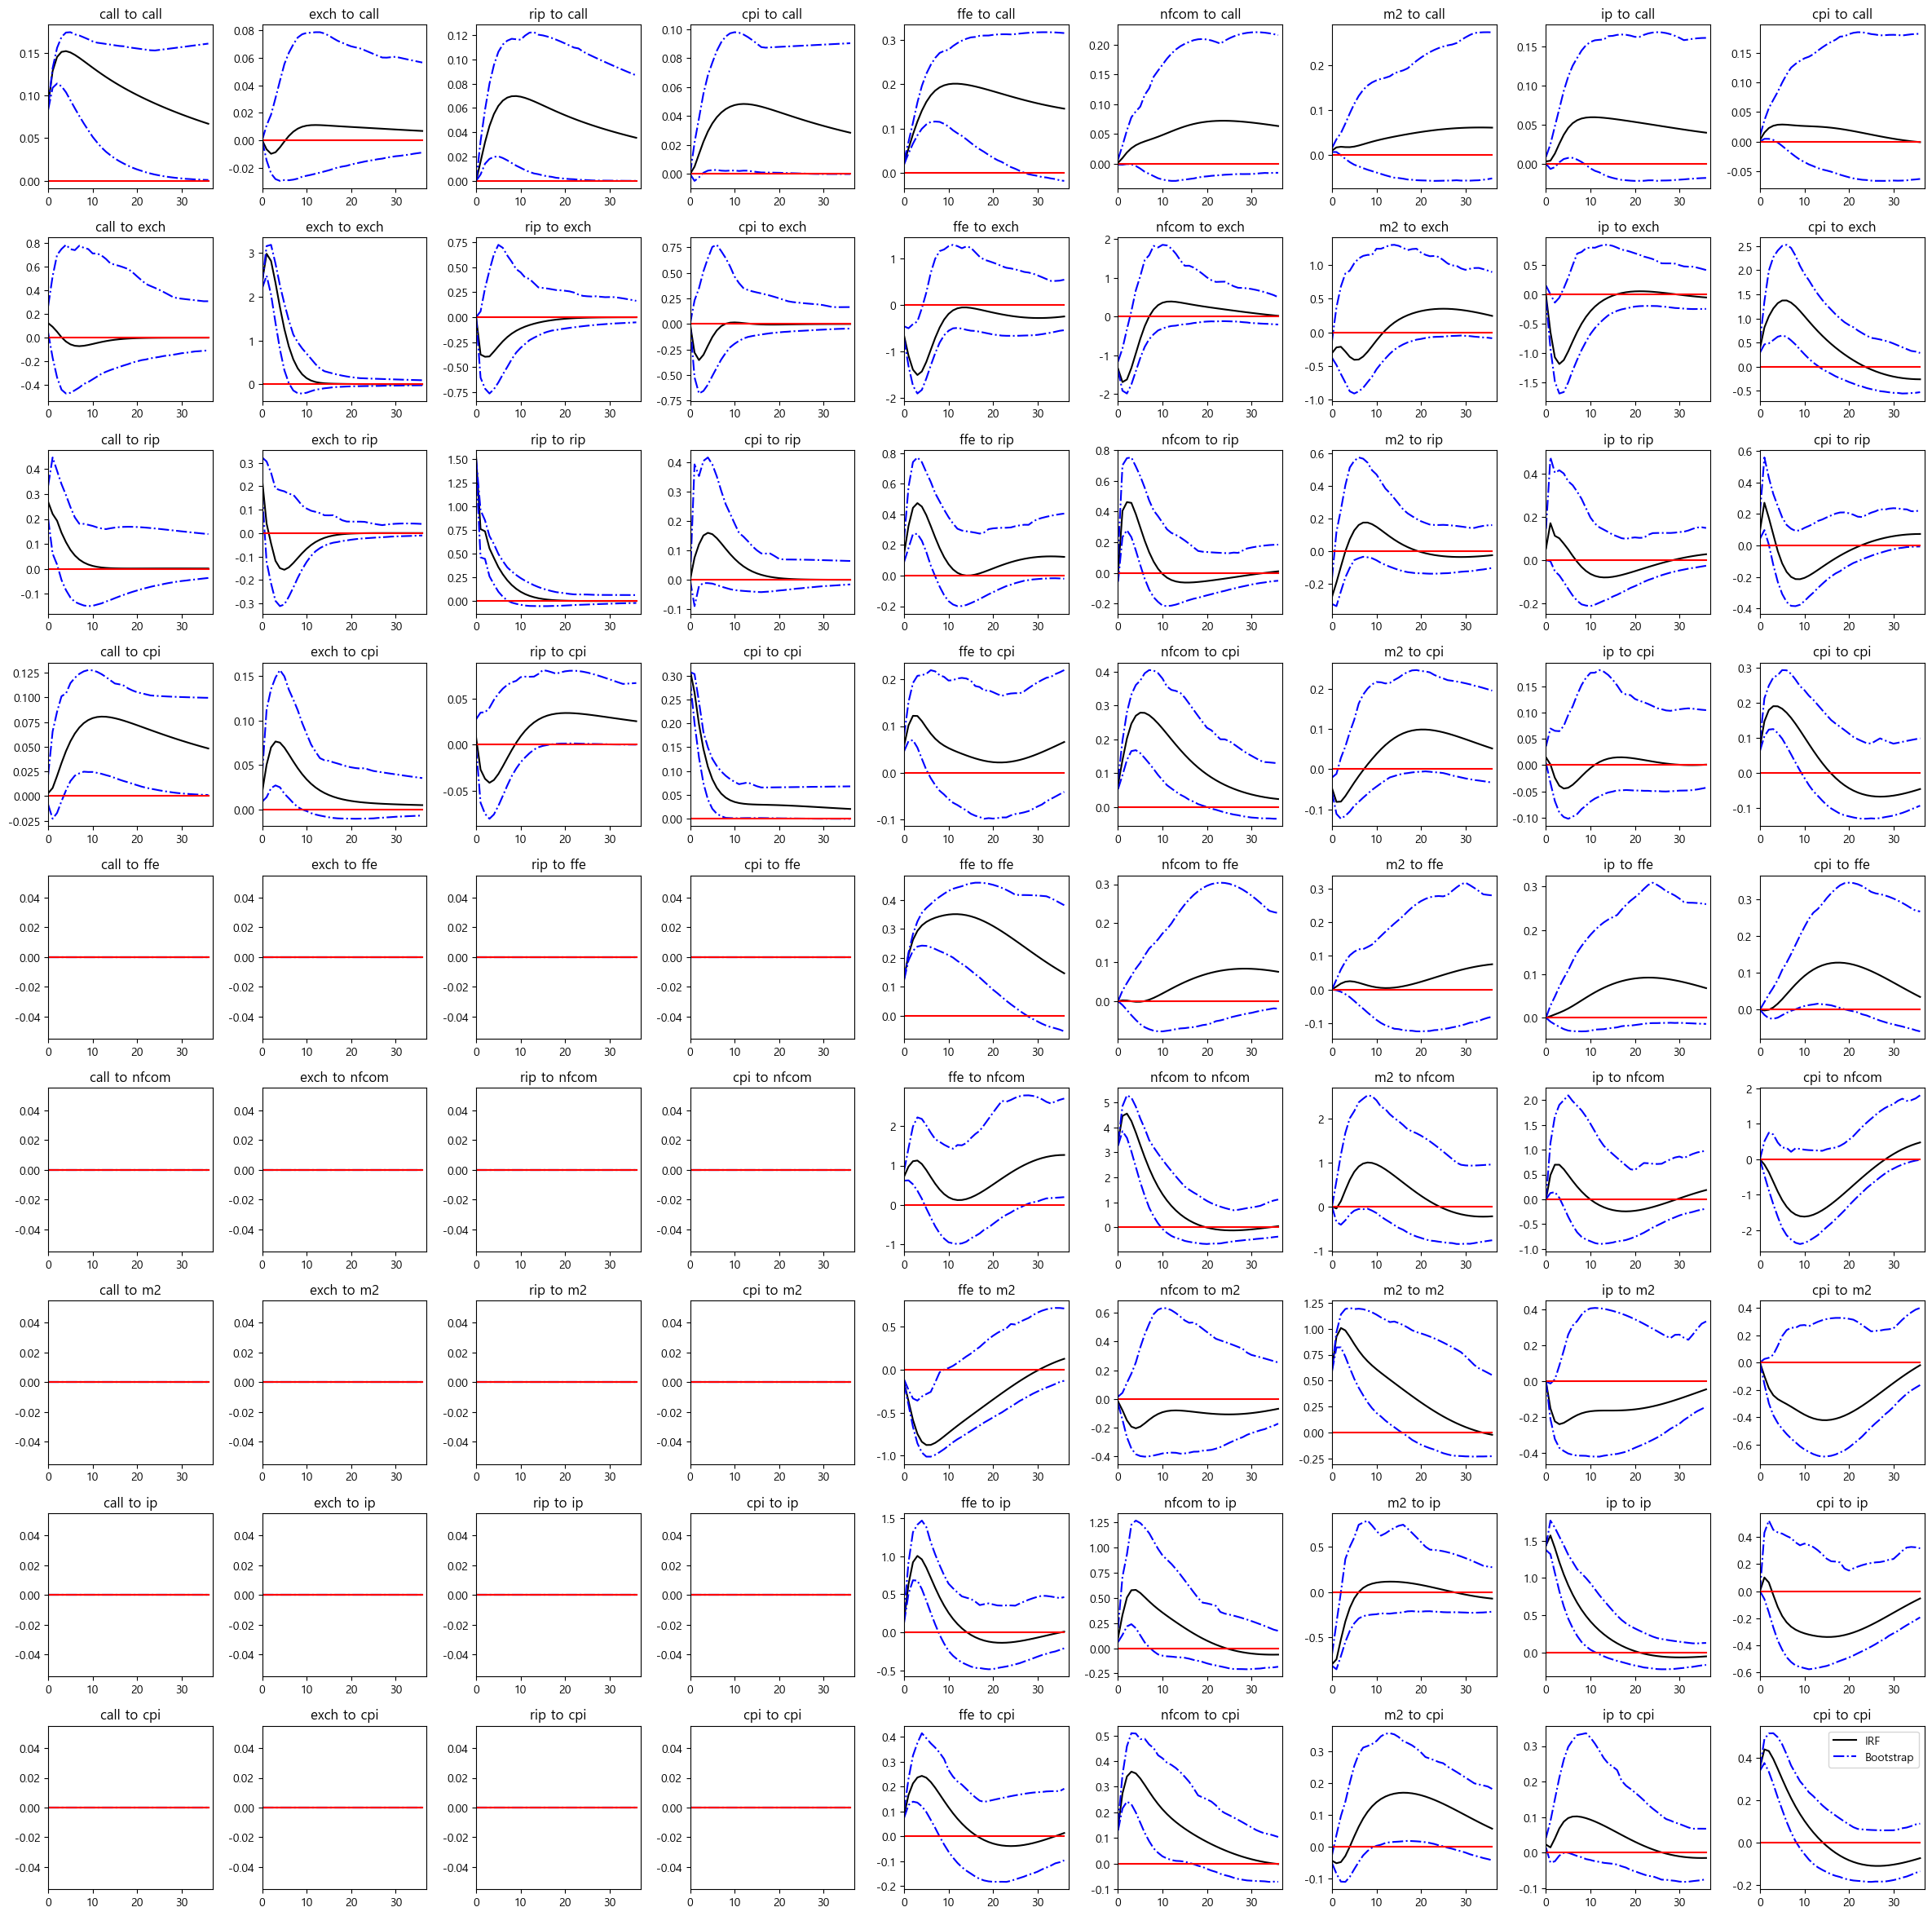

In [6]:
res.plot_irf(title=False)

누적충격반응함수를 그리는 경우, `plot_irf` 메서드 인자에 `cum=True`를 입력하면 된다.

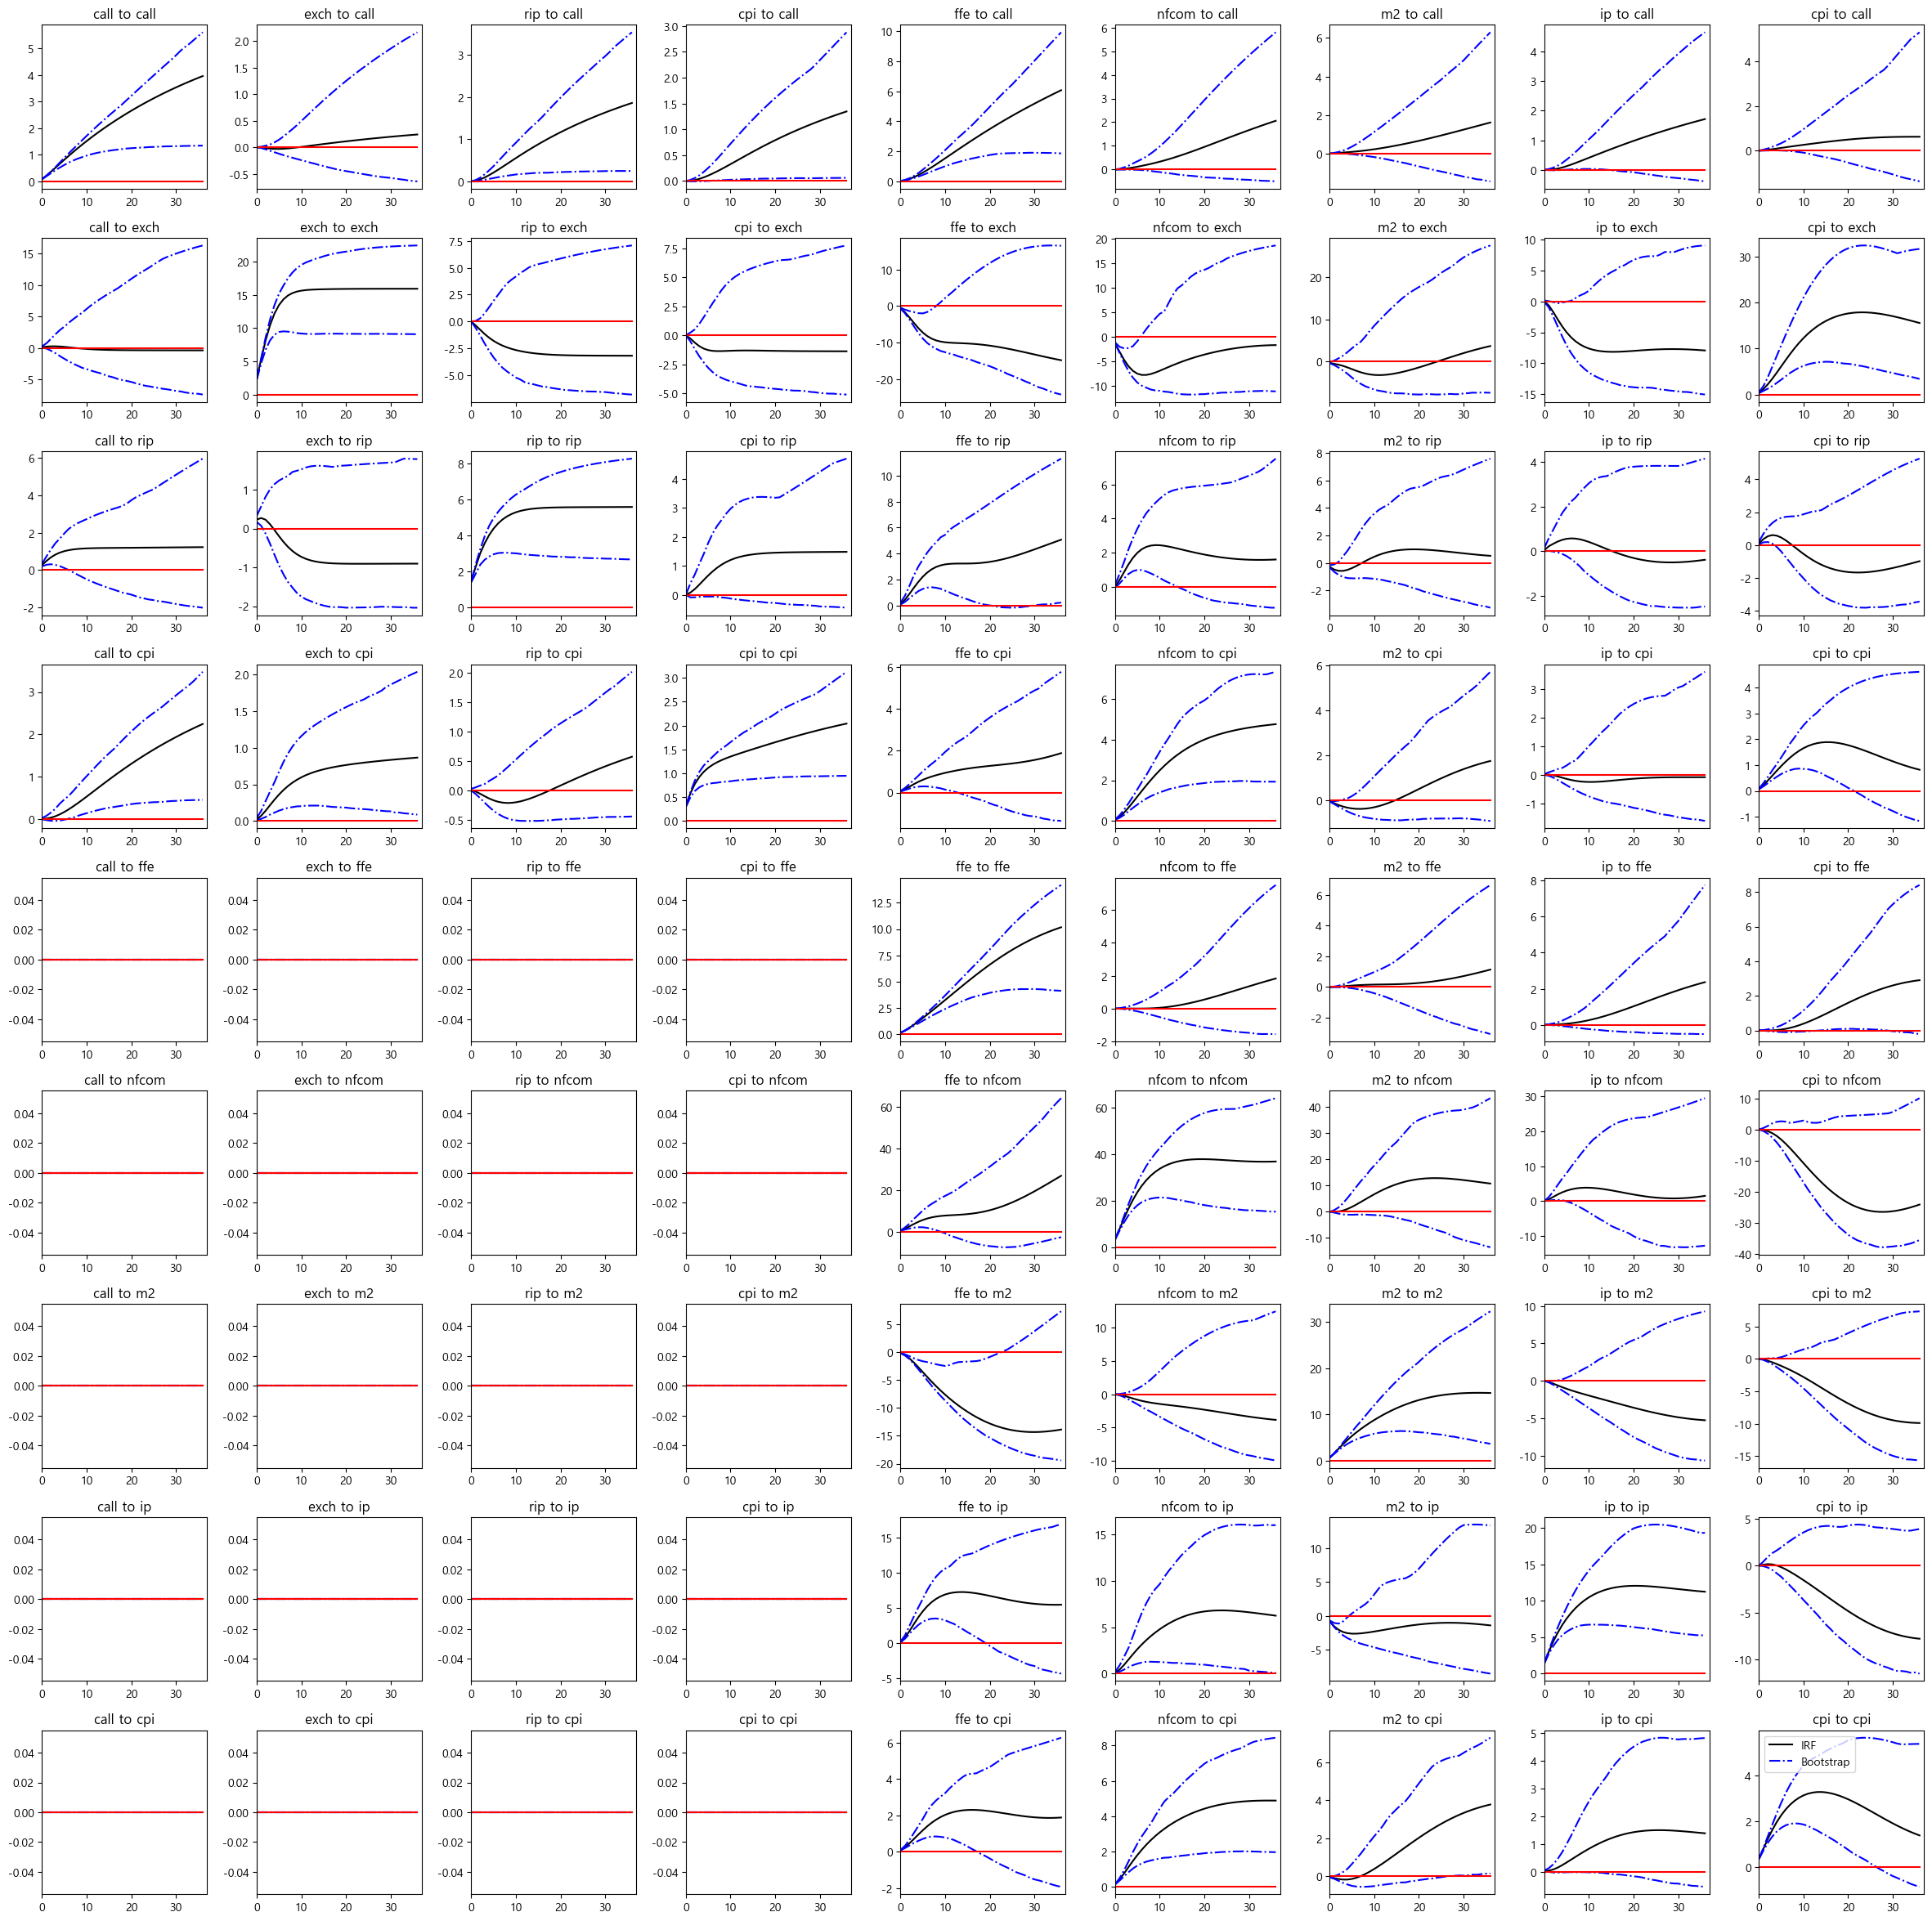

In [7]:
res.plot_irf(cum=True, title=False)

함수를 직접 사용하는 방법외에 `BlockVectorAutoRegression` 클래스를 이용해서도 추정할 수 있다. `var` 서브패키지에서 `BlockVectorAutoRegression` 클래스를 `BlockVAR`로 불러와 사용한다.

In [8]:
from bok_da.ts.var import BlockVectorAutoRegression as BlockVAR

`BlockVAR` 클래스를 이용해 `model` 객체를 생성하고, `fit` 메서드를 이용해 추정한다.

In [9]:
model = BlockVAR()
res = model.fit(df1, df2)

In [10]:
pd.set_option('display.expand_frame_repr', False) # print할 때, 줄바꿈 하지 않도록하는 디스플레이 옵션

for i in range(res.lag):
    print(pd.DataFrame(res.phi_hat[i]).T)

          0         1         2         3    4    5    6    7    8
0  1.412615 -0.003733  0.998449  0.107384  0.0  0.0  0.0  0.0  0.0
          0         1         2        3    4    5    6    7    8
0 -0.003967  1.299739 -0.033307  0.01651  0.0  0.0  0.0  0.0  0.0


위와 같이 BlockVAR 클래스에 lag 인자를 입력하지 않으면, 기본값인 None으로 처리되어 내부에서 BIC를 기준으로 시차를 선택해 모형이 설정된다. fit 메서드에 irf 인자를 입력하지 않는 경우 충격반응함수 분석은 수행하지 않고, 입력된 데이터에 대한 축약형 VAR(p) 모형 추정치를 리턴한다.

여기서 fit 메서드의 결과 인스턴스인 res는 다음의 결과를 포함한다.
</br>
`phi_hat`: 축약형 VAR(p) 모형의 계수 행렬 추정량
</br>
`sig_hat`: 축약형 VAR(p) 모형의 분산-공분산 행렬 추정량
</br>
`g0_hat`: y20 계수의 OLS 추정량(가정: 글로벌 변수들이 도메스틱 변수들을 계수 및 오차항을 통해 동시다발적으로 영향을 미친다.)
</br>
`f_mat`: 축약형 VAR(p) 모형의 동반행렬 형태의 계수 행렬 추정량
</br>
`y`:추정에 사용된 완전한 VAR 시스템
</br>
`u_hat1`: 도메스틱 부분 시스템의 잔차항
</br>
`u_hat2`: 글로벌 부분 시스템의 잔차항
</br>
`lag`: 시차(None이면 BIC를 기준으로 선택된 값, None이 아니면 입력된 값)

fit 메서드에 `irf='short'` 또는 `'long'` 인자를 입력하면, 충격반응함수를 수행하고 모형 추정치와 충격반응함수 추정치를 모두 리턴한다.

In [11]:
res = model.fit(df1, df2, h=36, irf='short') # by default: lag=None, q=90, n=2000

여기서 res 인스턴스는 앞에서 설명한 block_var_irf_bootstrap함수와 동일한 결과를 리턴한다.

In [12]:
res.get_description()

,설명
theta,추정된 VAR(p) 모형의 충격반응함수
cilv,충격반응함수 신뢰구간의 하한
cihv,충격반응함수 신뢰구간의 상한
cum_theta,추정된 VAR(p) 모형의 누적된 충격반응함수
cum_cilv,누적된 충격반응함수 신뢰구간의 하한
cum_cihv,누적된 충격반응함수 신뢰구간의 상한
phi_hat,축약형 VAR(p) 모형의 계수 행렬 추정량
sig_hat,축약형 VAR(p) 모형의 분산-공분산 행렬 추정량
g0_hat,y20 계수의 OLS 추정량 (가정: 글로벌 변수들이 도메스틱 변수들을 계수 및 오...
f_mat,축약형 VAR(p) 모형의 동반행렬 형태의 계수 행렬 추정량


마찬가지로 res의 `plot_irf` 메서드를 이용해 충격반응함수를 그릴 수 있다.

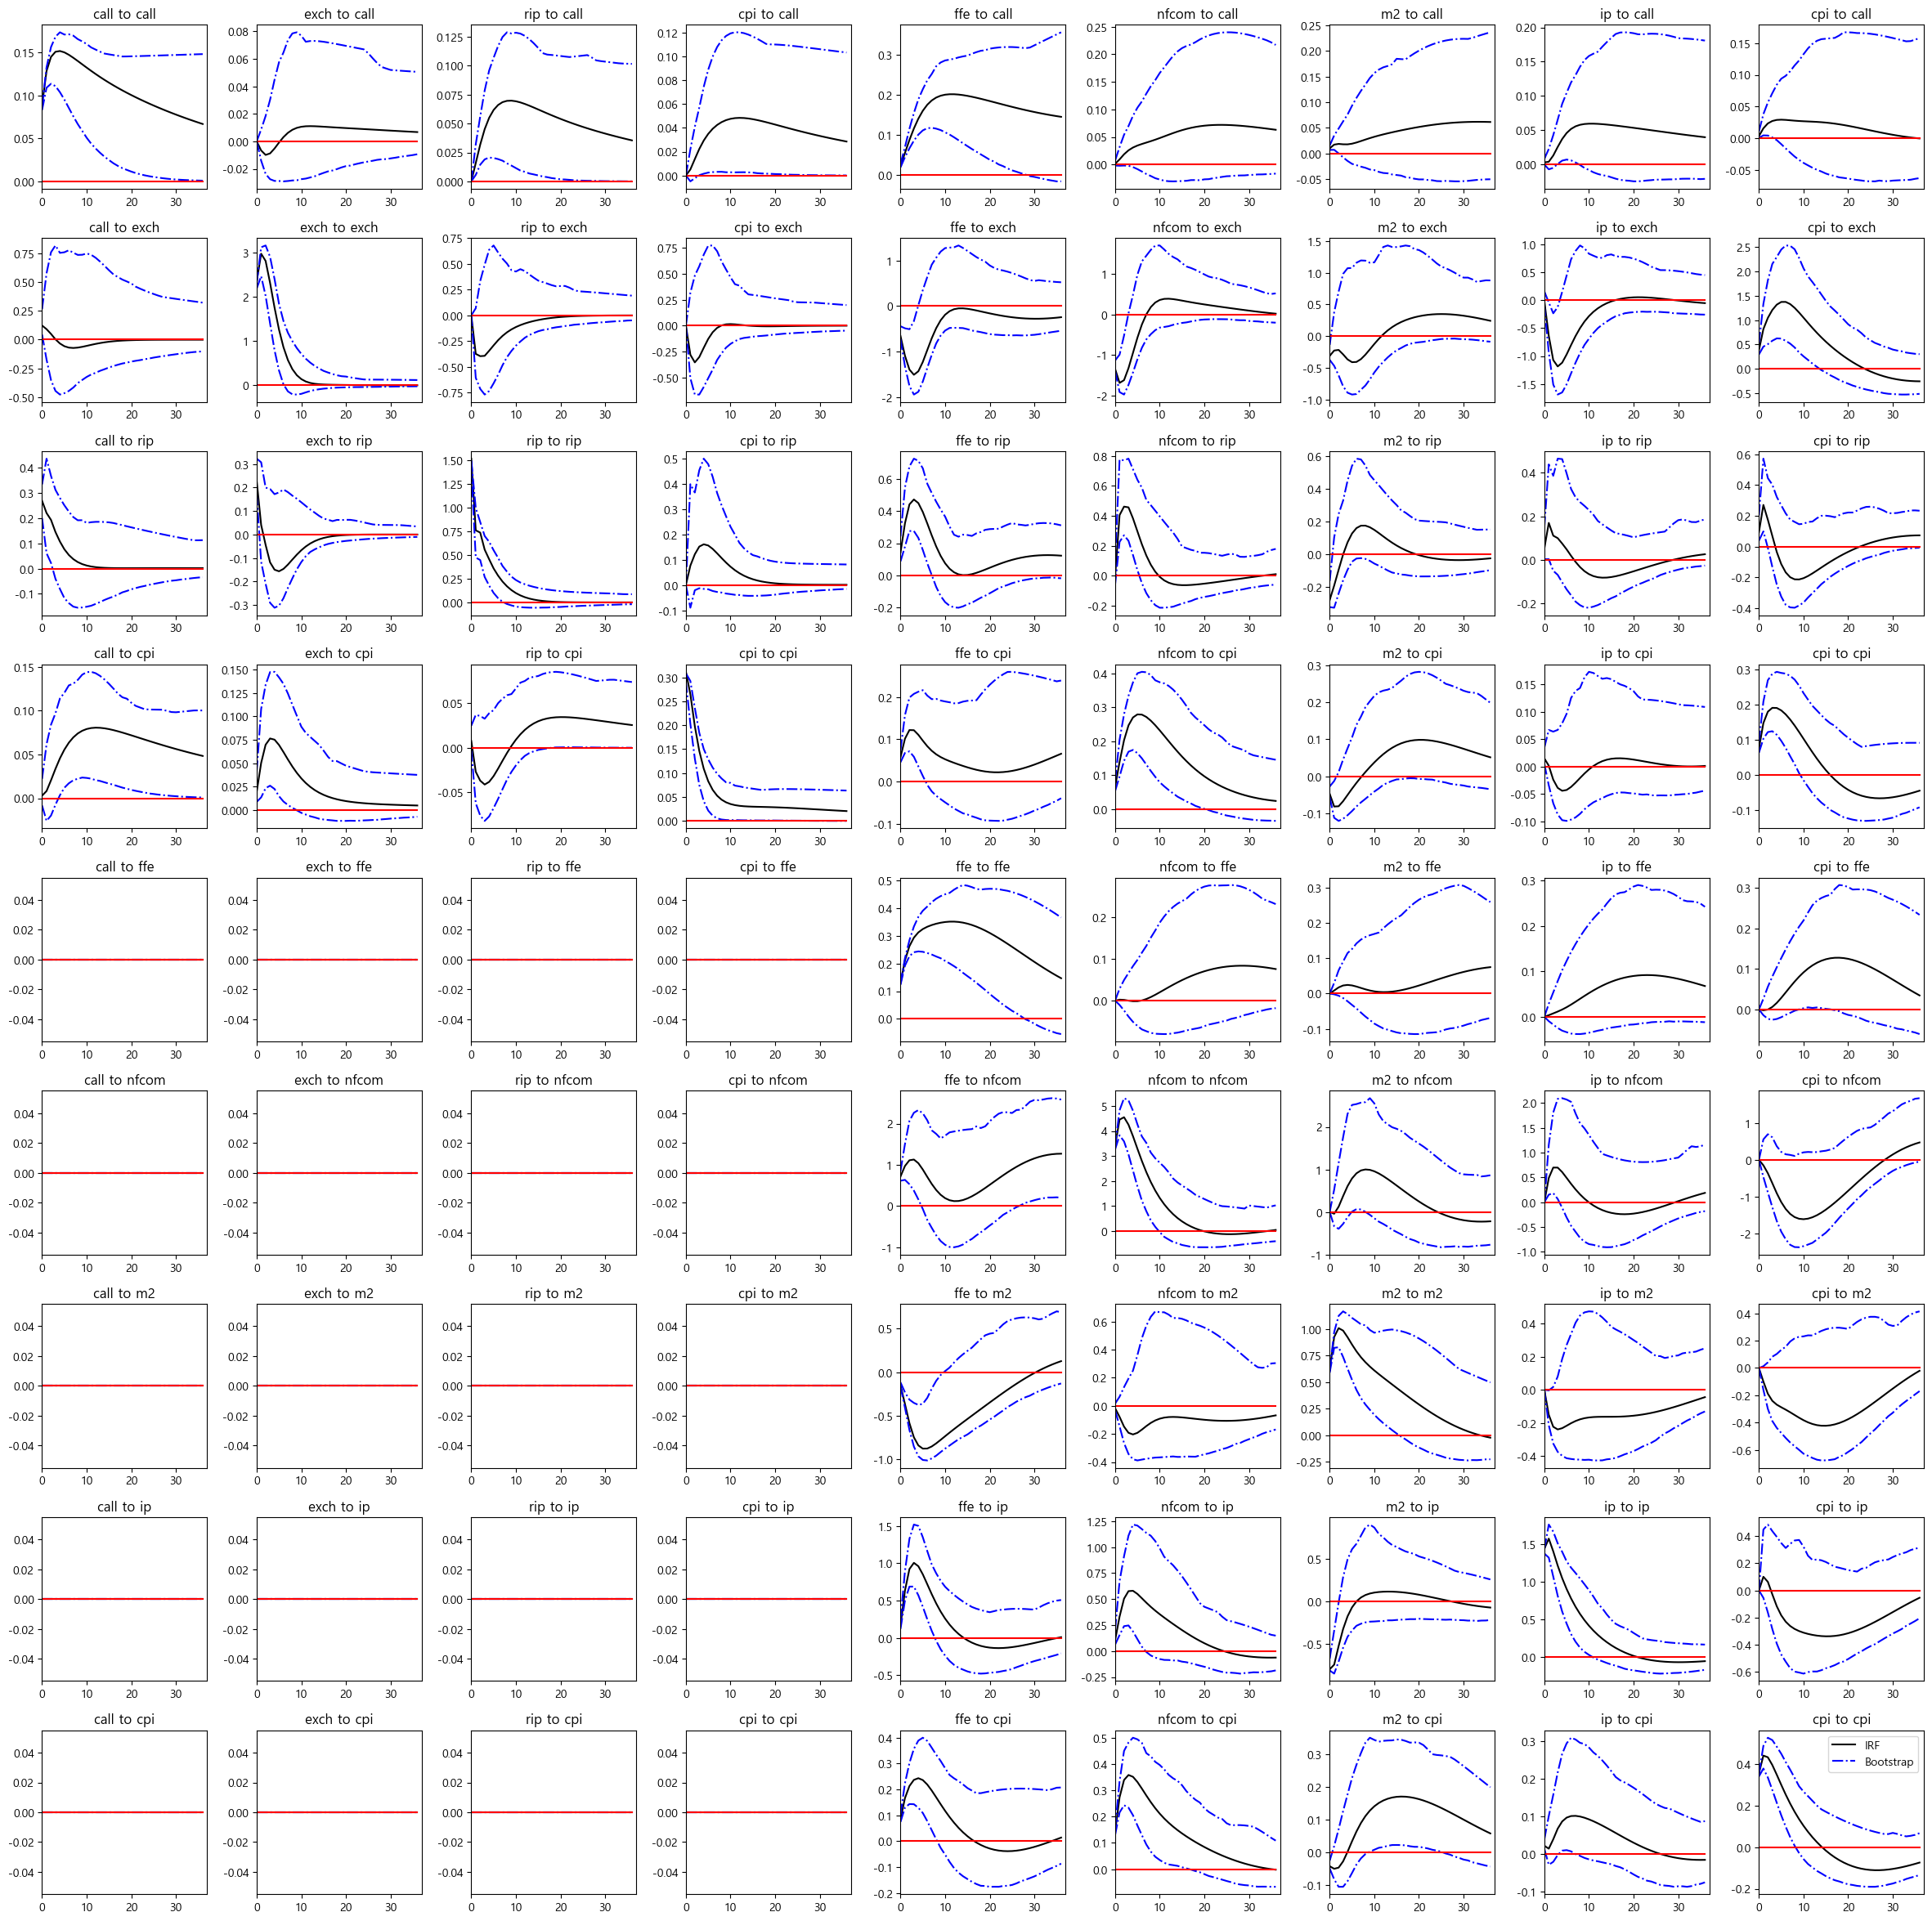

In [13]:
res.plot_irf(title=False)

### (참고) 블록 외생성 제약한 VAR 모형
블록 외생성 제약 하의 VAR(p) 모형 추정은 Lastrapes (2005)을 참고한다. 이때, 논문에서 추가적으로 가정한 도메스틱 부분 시스템의 대각 제약 (diagonal restriction)은 완화한다.

##### (1) 추정
우선 $y_{2t}$가 $y_{1t}$에 대해 블록 외생적이라는 블록 외생성 제약을 가정하자. 즉, 글로벌 변수들인 $y_{2t}$는 $y_{1t}$에 독립적으로 결정된다. 이러한 블록 외생성 제약을 명시적으로 보이기 위해, 축약형 VAR(p) 모형을 다음과 같이 분할하여 표현할 수 있다.
$\begin{equation}
    y_{t} = \begin{pmatrix}
        y_{1t} \\
        y_{2t}
    \end{pmatrix} = \sum_{i=1}^{p}{\begin{pmatrix}
        A_{11}^{i} & A_{12}^{i} \\
        0 & A_{22}^{i}
    \end{pmatrix}\begin{pmatrix}
        y_{1t-i} \\
        y_{2t-i}
    \end{pmatrix}} + \begin{pmatrix}
        u_{1t} \\
        u_{2t}
    \end{pmatrix} \tag{1}
\end{equation}$
또한, 축약형 VAR(p) 모형의 분산-공분산 행렬 역시 다음과 같이 분할하여 표현할 수 있다.
$\begin{equation}
    \Sigma = \mathbb{E}\begin{pmatrix}
        u_{1t} \\
        u_{2t}
    \end{pmatrix}\begin{pmatrix}
        u_{1t}^{\prime} & u_{2t}^{\prime} 
    \end{pmatrix} = \begin{pmatrix}
        \Sigma_{11} & \Sigma_{12} \\
        \Sigma_{21} & \Sigma_{22}
    \end{pmatrix} \tag{2}
\end{equation}$
이때, 블록 외생성 제약 하에서 VAR 시스템의 각 식에 해당하는 설명변수들이 달라져서 OLS 추정량이 효율적이지 않아지는 문제가 발생한다. 하지만, 위 (1) 식은 다음과 같이 모수변환 (reparametrized)하여 독립적인 식으로 표현할 수 있다.
$\begin{align}
    & y_{1t} = \sum_{i=1}^{p}{A_{11}^{i}y_{1t-i}} + \sum_{i=0}^{p}{G_{i}y_{2t-i}} + v_{t} \tag{3} \\
    & y_{2t} = \sum_{i=1}^{p}{A_{22}^{i}y_{2t-i}} + u_{2t} \tag{4}
\end{align}$
where
$\begin{align}
    & G_{0} = \Sigma_{12}\Sigma_{22}^{-1} \tag{5} \\
    & G_{i} = A_{12}^{i} - G_{0}\cdot A_{22}^{i} \tag{6} \\
    & \mathbb{E}(v_{t}v_{t}^{\prime}) \equiv H = \Sigma_{11}-\Sigma_{12}\Sigma_{22}^{-1}\Sigma_{12}^{\prime} \tag{7}
\end{align}$
이때, 식 (3)에서 $i=0$부터 시작하는 합산 과정은 글로벌 변수들이 도메스틱 변수들에 대해 오차항 사이의 상관관계와 더 직접적으로 $G_{0}$라는 계수를 통해 동시다발적인 효과를 준다는 것이 암묵적으로 가정되어 있다.

한편, 식 (3)과 (4)로 표현된 축약형 VAR 모형의 부분 시스템들이 독립적으로 추정되었다면, 식 (5)에서 (7)의 관계를 사용하여 식 (1)과 식 (2)로 표현된 최초의 계수 행렬 및 분산-공분산 행렬을 복구할 수 있다.
1. 계수  
    - $\hat{A}_{11}^{i}$와 $\hat{A}_{22}^{i}$

    위 계수들은 식 (3)과 (4)를 통해 바로 추정될 수 있다.

    - $\hat{A}_{12}^{i}$  
    
    식 (3)에서 $i=0,\cdots,p$에 대한 $\hat{G}_{i}$가 추정된다면 식 (6)을 사용하여 다음과 같이 $\hat{A}_{12}^{i}$을 복구시킬 수 있다.
    $\begin{equation}
        \hat{A}_{12}^{i} = \hat{G}_{i} + \hat{G}_{0}\cdot\hat{A}_{22}^{i} \notag
    \end{equation}$

    - $\hat{A}_{21}^{i}$  

    블록 외생성 제약을 통해
    $\begin{equation}
        \hat{A}_{21}^{i} = 0_{(k_{2}\times k_{1})} \notag
    \end{equation}$
    이 된다.

2. 분산-공분산 행렬  
    - $\hat{\Sigma}_{22}$

    $\Sigma_{22}$는 식 (4)를 통해 다음과 같이 직접적으로 추정될 수 있다. 우선 다음과 같은 잔차항을 도출한다.
    $\begin{equation}
            \hat{u}_{2t} = y_{2t} - \sum_{i=1}^{p}{\hat{A}_{22}^{i}y_{2t-1}} \notag
    \end{equation}$
    이를 사용하여 다음과 같이 $\hat{\Sigma}_{22}$을 추정한다.
    $\begin{equation}
            \hat{\Sigma}_{22} = \frac{\hat{u}_{2t}\hat{u}_{2t}^{\prime}}{T-p\cdot k_{2}} \notag
    \end{equation}$

    - $\hat{\Sigma}_{12}$

    $\hat{\Sigma}_{22}$가 도출되었기 때문에 이를 식 (5)에 활용하여 다음과 같이 $\hat{\Sigma}_{12}$를 도출할 수 있다.
    $\begin{equation}
            \hat{\Sigma}_{12} = \hat{G}_{0}\cdot\hat{\Sigma}_{22} \notag
    \end{equation}$

    - $\hat{\Sigma}_{11}$

    식 (3)을 추정하여 분산-공분산 행렬의 추정량 $\hat{H}$를 얻을 수 있다. 또한, $\hat{\Sigma}_{12}$와 $\hat{\Sigma}_{22}$가 도출되었기 때문에 이들을 식 (7)에 대입하여 다음과 같이 $\hat{Sigma}_{11}$을 구할 수 있다.
    $\begin{equation}
            \hat{\Sigma}_{11} = \hat{H} + \hat{\Sigma}_{12}\hat{\Sigma}_{22}^{-1}\hat{\Sigma}_{12}^{\prime} \notag
    \end{equation}$

##### (2) 식별
축약형 VAR 모형의 파라미터를 추정한 이후 단기 제약 또는 장기 제약을 통해 구조형 VAR 모형을 식별할 수 있다. 각 방법을 구체적으로 설명하기 전에 구조형 VAR 모형은
\begin{align*}
    & B(L)y_{t} = \varepsilon_{t} \\
    & \Rightarrow y_{t} = B(L)^{-1}\varepsilon_{t} \equiv \Theta(L)\varepsilon_{t}
\end{align*}
축약형 VAR 모형은
\begin{align*}
    & A(L)y_{t} = u_{t} \\
    & \Rightarrow y_{t} = A(L)^{-1}u_{t} \equiv \Psi(L)u_{t}
\end{align*}
의 무한기 MA 과정으로 표현할 수 있다. 이를 통해
\begin{align}
    & \Theta_{0} = B_{0}^{-1} \tag{8} \\
    & \Theta_{i} = \Psi_{i}\Theta_{0} \tag{9}
\end{align}

##### (i) 단기 제약을 통한 식별
구조형 VAR 모형을 축약형 VAR 모형으로 변환하는 과정을 통해
\begin{align*}
        & A_{i} = B_{0}^{-1}B_{i} \iff B_{0}A_{i} = B_{i} \\
        & u_{t} = B_{0}^{-1}\varepsilon_{t} \iff B_{0}u_{t} = \varepsilon_{t}
\end{align*}
와 같은 관계를 도출할 수 있다. 이를 통해 $u_{t}$의 분산-공분산 행렬은 다음과 같이 도출할 수 있다.
\begin{equation*}
    \mathbb{E}(u_{t}u_{t}^{\prime}) = \mathbb{E}(B_{0}^{-1}\varepsilon_{t}\varepsilon_{t}^{\prime}{B_{0}^{-1}}^{\prime}) = B_{0}^{-1}I_{k}{B_{0}^{-1}}^{\prime} = \Sigma
\end{equation*}
이러한 형태는 식 (8)의 관계를 통해 다음과 같이 partiion된 형탤로 표현될 수 있다.
\begin{align*}
    & \Sigma = \Theta_{0}\Theta_{0}^{\prime} \notag \\
    & \Rightarrow \begin{pmatrix}
        \Sigma_{11} & \Sigma_{12} \\
        \Sigma_{21} & \Sigma_{22}
    \end{pmatrix} = \begin{pmatrix}
        \Theta_{11}^{0}{\Theta_{11}^{0}}^{\prime} + \Theta_{12}^{0}{\Theta_{12}^{0}}^{\prime} & \Theta_{12}^{0}{\Theta_{22}^{0}}^{\prime} \\
        \Theta_{22}^{0}{\Theta_{12}^{0}}^{\prime} & \Theta_{22}^{0}{\Theta_{22}^{0}}^{\prime}
    \end{pmatrix}
\end{align*}
따라서 구조형 모형의 식별을 담당하는 $\Theta_{0}=B_{0}^{-1}$는 다음과 같은 순서로 도출할 수 있다.
1. $\Theta_{22}^{0}=(B_{22}^{0})^{-1}$

    우선, $\Sigma_{22}$에 춀레스키 분해를 사용함으로서 $B_{0}^{-1}$ 행렬의 (2,2) partition을 도출할 수 있다. 즉,
\begin{equation*}
    \Theta_{22}^{0}=(B_{22}^{0})^{-1} = chol(\Sigma_{22})
\end{equation*}

2. $\Theta_{12}^{0}=(B_{12}^{0})^{-1}$

    위에서 도출된 $\Theta_{22}^{0}$를 사용하여 다음과 같은 관계를 통해 $\Theta_{12}^{0}$을 도출할 수 있다.
\begin{align*}
    & \Sigma_{12} = \Theta_{12}^{0}{\Theta_{22}^{0}}^{\prime} \\
    & \Rightarrow \Theta_{12}^{0} = \Sigma_{12}({\Theta_{22}^{0}}^{\prime})^{-1}
\end{align*}

3. $\Theta_{11}^{0}=(B_{11}^{0})^{-1}$

    마지막으로 위에서 도출된 $\Theta_{12}^{0}$와 $\Theta_{22}^{0}$을 사용하여 다음과 같은 관계를 도출할 수 있다.
\begin{align*}
    & \Sigma_{11} = \Theta_{11}^{0}{\Theta_{11}^{0}}^{\prime} + \Theta_{12}^{0}{\Theta_{12}^{0}}^{\prime} \\
    & \Rightarrow \Theta_{11}^{0}{\Theta_{11}^{0}}^{\prime} = \Sigma_{11} - \Theta_{12}^{0}{\Theta_{12}^{0}}^{\prime}
\end{align*}
    이후 해당 관계에 다음과 같은 춀레스키 분해를 통해 $\Theta_{11}^{0}$를 도출할 수 있다.
\begin{equation*}
    \Theta_{11}^{0} = chol(\Sigma_{11} - \Theta_{12}^{0}{\Theta_{12}^{0}}^{\prime})
\end{equation*}

결과적으로 춀레스키 분해가 적용된 $\Theta_{11}^{0}$와 $\Theta_{22}^{0}$가 하방 삼각행렬 형태인 관계로 부분-시스템 $y_{1t}$와 $y_{2t}$ 각각의 변수 순서가 중요함을 알 수 있다.

##### (ii) 장기 제약을 통한 식별
한편, VAR 모형의 경우 같이 블록 외생성 제약 하에서의 VAR 모형에서도 장기 제약을 통한 식별을 할 수 있다. 구조형 및 축약형 VAR 모형의 시차 다항식 (lag polynomial)을 사용하면, 다음과 같은 관계를 도출할 수 있다.
\begin{align}
    & B_{0}^{-1}B(L) = A(L) \notag \\
    & \Rightarrow B_{0}^{-1} = A(L)B(L)^{-1} \notag \\
    & \Rightarrow B_{0}^{-1} = A(1)\Theta(1) \tag{10}
\end{align}
나아가 구조형 VAR과 축약형 VAR 모형의 장기분산은 다음과 같은 관계로 이어진다.
\begin{equation}
    \Theta(1)\Theta(1)^{\prime} = \Psi(1)\Sigma\Psi(1)^{\prime} \notag
\end{equation}
해당 관계는 행렬의 partition으로 다음과 같이 표현할 수 있다.
$\begin{align}
    & \begin{pmatrix}
        \Theta(1)_{11}\Theta(1)_{11}^{\prime}+\Theta(1)_{12}\Theta(1)_{12}^{\prime} & \Theta(1)_{12}\Theta(1)_{22}^{\prime} \\
        \Theta(1)_{22}\Theta(1)_{12}^{\prime} & \Theta(1)_{22}\Theta(1)_{22}^{\prime}
    \end{pmatrix} = \notag \\
    &\hspace{10ex} \begin{pmatrix}
        \Psi(1)_{11} & \Psi(1)_{12} \\
        0 & \Psi(1)_{22}
    \end{pmatrix}\begin{pmatrix}
        \Sigma_{11} & \Sigma_{12} \\
        \Sigma_{21} & \Sigma_{22}
    \end{pmatrix}\begin{pmatrix}
        \Psi(1)_{11}^{\prime} & 0 \\
        \Psi(1)_{12}^{\prime} & \Psi(1)_{22}^{\prime}
    \end{pmatrix} \tag{11}
\end{align}$
이때, $\Sigma$는 축약형 VAR의 추정으로 추정되었으며, $\Psi(1)$ 역시 추정된 축약형 VAR의 계수 행렬 추정치를 통해 다음과 같이 도출될 수 있다.
\begin{equation}
    \hat{\Psi}(1) = \hat{A}(1)^{-1} = (I-\hat{A}_{1}-\cdots-\hat{A}_{p})^{-1} \notag
\end{equation}
따라서 식 (10)과 (11)을 사용하면 다음과 같은 단계를 통해 $B_{0}^{-1}$을 식별할 수 있다.

- $\Theta(1)_{22}$

    먼저, 식 (11)에서 다음 관계를 알 수 있다.
    $\begin{equation}
        \Theta(1)_{22}\Theta(1)_{22}^{\prime} = \hat{\Psi}(1)_{22}\hat{\Sigma}_{22}\hat{\Psi}(1)_{22}^{\prime} \notag
    \end{equation}$
    이후, 춀레스키 분해를 사용하면 $\Theta(1)_{22}$를 도출할 수 있다.
    $\begin{equation}
        \Theta(1)_{22} = chol(\hat{\Psi}(1)_{22}\hat{\Sigma}_{22}\hat{\Psi}(1)_{22}^{\prime}) \notag
    \end{equation}$

- $\Theta(1)_{12}$

    식 (11)에서 다음과 같은 관계를 알 수 있다.
    $\begin{equation}
        \Theta(1)_{12}\Theta(1)_{22}^{\prime} = \hat{\Psi}(1)\hat{\Sigma}_{12}\hat{\Psi}(1)_{22}^{\prime} + \hat{\Psi}(1)_{12}\hat{\Sigma}_{22}\hat{\Psi}(1)_{22}^{\prime} \notag
    \end{equation}$
    이때, 이전 단계에서 $\Theta(1)_{22}$를 도출하였기 때문에 다음과 같이 $\Theta(1)_{12}$를 도출할 수 있다.
    $\begin{equation}
        \Theta(1)_{12} = [\hat{\Psi}(1)\hat{\Sigma}_{12}\hat{\Psi}(1)_{22}^{\prime} + \hat{\Psi}(1)_{12}\hat{\Sigma}_{22}\hat{\Psi}(1)_{22}^{\prime}]\cdot(\Theta(1)_{22}^{\prime})^{-1} \notag
    \end{equation}$

- $\Theta(1)_{11}$

    마지막으로 식 (11)에서 다음과 같은 관계를 알 수 있다.
    $\begin{align}
        & \Theta(1)_{11}\Theta(1)_{11}^{\prime} + \Theta(1)_{12}\Theta(1)_{12}^{\prime} \notag \\
        & \hspace{5ex} = \hat{\Psi}(1)_{11}\hat{\Sigma}_{11}\hat{\Psi}(1)_{11}^{\prime} + \hat{\Psi}(1)_{12}\hat{\Sigma}_{21}\hat{\Psi}(1)_{11}^{\prime} + \hat{\Psi}(1)_{11}\hat{\Sigma}_{12}\hat{\Psi}(1)_{12}^{\prime} + \hat{\Psi}(1)_{12}\hat{\Sigma}_{22}\hat{\Psi}(1)_{12}^{\prime} \notag \\
        & \hspace{5ex} \equiv L_{11} \notag
    \end{align}$
    이후, 춀레스키 분해를 사용하면 $\Theta(1)_{11}$을 도출할 수 있다.
    $\begin{equation}
        \Theta(1)_{11} = chol\Bigg(L_{11}-\Theta(1)_{12}\Theta(1)_{12}^{\prime}\Bigg) \notag
    \end{equation}$

- $B_{0}^{-1}$ 식별

    우리는 지금까지 다음과 같이 구성된 $\Theta(1)$을 도출하였다.
    $\begin{equation}
        \hat{\Theta}(1) = \begin{pmatrix}
            \Theta(1)_{11} & \Theta(1)_{12} \\
            0 & \Theta(1)_{22}
        \end{pmatrix} \notag
    \end{equation}$
    따라서 식 (10)의 관계를 사용하면 다음과 같이 $B_{0}^{-1}$을 식별할 수 있다.
    $\begin{equation}
        B_{0}^{-1} = \hat{A}(1)\hat{\Theta}(1) \notag
    \end{equation}$